# Astronomical python packages

In this lecture we will introduce the astropy library and the
affiliated package astroquery.
The official documents of these packages are available at:

- http://docs.astropy.org/en/stable/index.html#

- https://astroquery.readthedocs.io/en/latest/

To install these packages with conda:

```bash
conda install astropy
conda install -c astropy astroquery
```
There are many more packages affiliated to astropy which can be of interest
to you. You can find the list at:

http://www.astropy.org/affiliated/

## FITS files

FITS files are by far the favorite format to store and distribute astronomical data.
They come in two flavors:

- images
- tables

To read these two types of files we will need to import from astropy two different
sub-libraries:

``` python
from astropy.io import fits
from astropy.table import Table
```
FITS files can store multi-dimensional data (commonly 2 or 3 dimensions).
Any given FITS file can contain multiple images (or tables) called extensions.
Every FITS extension contains a header and data.
FITS headers can contain World Coordinate System (wcs) information that indicates where a given pixel is on the sky.

Unlike Python, the FITS convention is indexing starting at 1.
Generally, astropy takes this into account.

![title](img/fits.png)

### Reading a FITS file

Convenience functions make reading FITS images easy.

```python
from astropy.io import fits
img1 = fits.getdata(filename) # Getting the image
head1 = fits.getheader(filename) # and the Header
```
This opens the image as a Numpy array, and the header as a
“dictionary-like” object (i.e., you can access the individual header keywords through “head1[‘key’]” ).

To open other extensions in the fits file:
```python
img1 = fits.getdata(filename, 0) # Primary Ext
img2 = fits.getdata(filename, 1) # Second Ext
img2 = fits.getdata(filename, ext=1) # Equivalent
```
It is possible to import a FITS file also using an URL.
This is done with the download_file function.


In [1]:
from astropy.utils.data import download_file
from astropy.io import fits

image_file = download_file('http://data.astropy.org/tutorials/FITS-images/HorseHead.fits',
                           cache=True)

To have some information about the file we just open, we can use the fits.info method:

In [2]:
fits.info(image_file)

Filename: /home/marleau/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Then, we can decide to open an exstension, check its shape and eventually plot it with
matplolib imshow.

In [3]:
image_data = fits.getdata(image_file, ext=0)
image_data.shape

(893, 891)

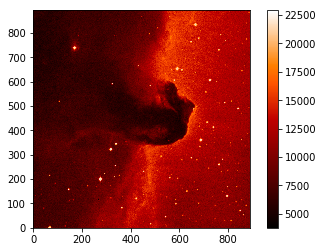

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.imshow(image_data, cmap='gist_heat',origin='lower')
plt.colorbar();

## Reading a FITS file - the general way

In a more general way, it is better to define a HDU list (Header Data Unit list) which 
contains the list of all the goodies stored in a FITS file.
Then, get only what we need. First, let's open the list:

In [5]:
hdulist = fits.open(image_file)
hdulist.info()

Filename: /home/marleau/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Next, we can extract header and data from the first extension.
We can do this in two ways:

- by specifying the extension number
- by specifying the extension name, if defined


In [6]:
header = hdulist['PRIMARY'].header
data = hdulist['PRIMARY'].data

FITS files are read in such a way that the first axis (often the RA for astronomical images) is read in as the last axis in the numpy array. Be sure to double check that you have the axis you need.

We can, at this point, close the file.

In [7]:
hdulist.close()

Now, let's explore the header.
To print in a human readable way, it's useful to use the **repr** function which adds line breaks in between the keywords:



In [8]:
print(repr(header[:10]))     # Beginning of the header

SIMPLE  =                    T /FITS: Compliance                                
BITPIX  =                   16 /FITS: I*2 Data                                  
NAXIS   =                    2 /FITS: 2-D Image Data                            
NAXIS1  =                  891 /FITS: X Dimension                               
NAXIS2  =                  893 /FITS: Y Dimension                               
EXTEND  =                    T /FITS: File can contain extensions               
DATE    = '2014-01-09        '  /FITS: Creation Date                            
ORIGIN  = 'STScI/MAST'         /GSSS: STScI Digitized Sky Survey                
SURVEY  = 'SERC-ER '           /GSSS: Sky Survey                                
REGION  = 'ER768   '           /GSSS: Region Name                               


We can access the list of keywords, values, a specific keyword or comment:

In [9]:
print (header[:10].keys())
print (header[:10].values())
print (header['ORIGIN'])
print (header.comments['ORIGIN'])

<generator object Header.__iter__ at 0x7fee14ccaba0>
<generator object Header.values at 0x7fee14ccaba0>
STScI/MAST
GSSS: STScI Digitized Sky Survey


To extract the astrometry, we will use wcs package inside astropy.
This will allow us to display the image with astronomical coordinates

In [10]:
from astropy.wcs import WCS
wcs = WCS(header)
print(wcs)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 85.59941666666666  -4.946638888888889  
CRPIX : -716.333144294269  -8444.64946698226  
PC1_1 PC1_2  : 0.015029018460682027  -9.63735777657198e-06  
PC2_1 PC2_2  : 1.0548917307845708e-05  0.015000473845055023  
CDELT : -0.018654788242111486  0.018654788242111486  
NAXIS : 891  893


In the following, a plot with astrometry and some label customization.
For more details, have a look at this page:
https://github.com/astropy/astropy-api/blob/master/wcs_axes/wcs_api.md

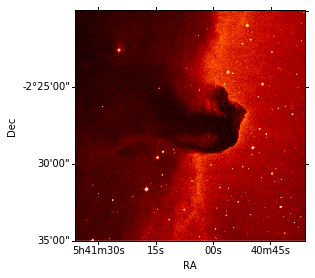

In [11]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs)
#ax = plt.subplot(projection=wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(data, cmap='gist_heat',origin='lower')
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss');

### Coordinate transformations

Astropy
provides a way of dealing with coordinates, and automatically deal with conversions:

```python
from astropy.coordinates import SkyCoord
# Making Coordinates:
c1 = SkyCoord(ra, dec, frame=‘icrs’, unit=‘deg’)
c2 = SkyCoord(l, b, frame=‘galactic’, unit=‘deg’)
c3 = SkyCoord(’00h12m30s’, ‘+42d12m00s’)
# Printing and Conversions:
c1.ra, c1.dec, c1.ra.hour, c2.ra.hms, c3.dec.dms
c2.fk5, c1.galactic # Converting Coordinates
c2.to_string(‘decimal’), c1.to_string(‘hmsdms’)
```
For instance, let's compute the coordinates of the center of the horse head:

In [12]:
from astropy.coordinates import SkyCoord
c0 = SkyCoord('5h41m00s','-2d27m00s',frame='icrs')
print(c0)

<SkyCoord (ICRS): (ra, dec) in deg
    (85.25, -2.45)>


### From pixel to coordinates and vice versa

The wcs object contains functions that conversion from pixel to world coordinates and vice versa. 

```python
# From pixel => world:
ra, dec= w.all_pix2world(xpx, ypx, 0)# Can be lists

# The third parameter indicates if you’re starting
# from 0 (Python-standard) or 1 (FITS-standard)

# From world => pixel:
xpx, ypx= w.all_world2pix(ra, dec, 0)
```

In [13]:
center = wcs.all_world2pix(c0.ra,c0.dec,0)
print (center)

[array(534.12352151), array(475.5504697)]


### Cutouts

It is not infrequent that we need only a part of an image. So, we would like to extract this part and save another FITS file with correct astrometry.
We can do this using the class **Cutout2D**.

This class allows one to create a cutout object from a 2D array. If a WCS object is input, then the returned object will also contain a copy of the original WCS, but updated for the cutout array.

In [14]:
from astropy.nddata import Cutout2D

size=400
cutout = Cutout2D(data, center, size, wcs=wcs)

print(cutout.bbox_original)

((276, 675), (334, 733))


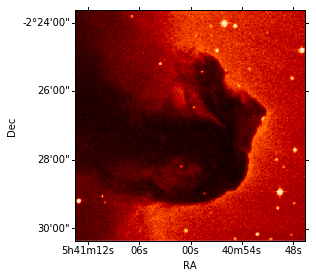

In [15]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], 
                  projection=cutout.wcs)
#ax = plt.subplot(projection=wcs)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(cutout.data, cmap='gist_heat',origin='lower')
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss');

### Save the new FITS file

To save the new fits we have to create the header, then the extensions,
finally pack all the extensions in a list and write the list to a file.

```python
# Making a Primary HDU (required):
primaryhdu= fits.PrimaryHDU(arr1)# Makes a header
# or if you have a header that you’ve created:
primaryhdu= fits.PrimaryHDU(arr1, header=head1)
# If you have additional extensions:
secondhdu= fits.ImageHDU(arr2)
# Making a new HDU List:
hdulist1 = fits.HDUList([primaryhdu, secondhdu])
# Writing the file:
hdulist1.writeto(filename, clobber=True)
```
The clobber=True instruction is given to allow the rewriting of a file over an existing file. Otherwise, Python refuses to overwrite.


In [16]:
cheader = cutout.wcs.to_header()
primaryhdu = fits.PrimaryHDU(cutout.data, cheader)
hdulist = fits.HDUList([primaryhdu])
hdulist.writeto('horse.fits', overwrite=True)

## Tables in astropy

While you can use the FITS interface to open tables,
Astropy makes it very easy and convienientwith the astropy.table interface.
For an extensive help on Tables, have a look to the documentation page:

http://docs.astropy.org/en/stable/table/

```python
from astropy.table import Table
# Getting the first table
t1 = Table.read(filename.fits)
# Getting the second table
t2 = Table.read(filename.fits, hdu=2)
```

This provides a
really flexible Table object that is a pleasure to deal with. It is easy to access different types of data, and read in and output to a wide variety of formats (not just FITS). Let's open the table in the extension 1 of the previous file:

In [17]:
hdulist = fits.open(image_file)
hdulist.info()

Filename: /home/marleau/.astropy/cache/download/py3/2c9202ae878ecfcb60878ceb63837f5f
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     161   (891, 893)   int16   
  1  er.mask       1 TableHDU        25   1600R x 4C   [F6.2, F6.2, F6.2, F6.2]   


Once imported, a table can be shown with a fancy notebook interface:

In [18]:
from astropy.table import Table
t = Table.read(image_file, hdu=1)
t[:10].show_in_notebook()

idx,XI,ETA,XI_CORR,ETA_CORR
,DEGREES,DEGREES,ARCSEC,ARCSEC
0,-3.12,-3.12,0.09,0.04
1,-2.96,-3.12,0.02,0.07
2,-2.8,-3.12,-0.07,0.15
3,-2.64,-3.12,-0.17,0.25
4,-2.48,-3.12,-0.29,0.26
5,-2.32,-3.12,-0.38,0.25
6,-2.16,-3.12,-0.42,0.15
7,-2.0,-3.12,-0.48,0.06
8,-1.84,-3.12,-0.47,-0.01


Or more simply printed:

In [19]:
print(t[:10])

   XI     ETA   XI_CORR ETA_CORR
DEGREES DEGREES  ARCSEC  ARCSEC 
------- ------- ------- --------
  -3.12   -3.12    0.09     0.04
  -2.96   -3.12    0.02     0.07
   -2.8   -3.12   -0.07     0.15
  -2.64   -3.12   -0.17     0.25
  -2.48   -3.12   -0.29     0.26
  -2.32   -3.12   -0.38     0.25
  -2.16   -3.12   -0.42     0.15
   -2.0   -3.12   -0.48     0.06
  -1.84   -3.12   -0.47    -0.01
  -1.68   -3.12   -0.47    -0.12


The format can be fixed:

In [20]:
t['ETA'].format = '4.1f'
print(t[:10])

   XI     ETA   XI_CORR ETA_CORR
DEGREES DEGREES  ARCSEC  ARCSEC 
------- ------- ------- --------
  -3.12    -3.1    0.09     0.04
  -2.96    -3.1    0.02     0.07
   -2.8    -3.1   -0.07     0.15
  -2.64    -3.1   -0.17     0.25
  -2.48    -3.1   -0.29     0.26
  -2.32    -3.1   -0.38     0.25
  -2.16    -3.1   -0.42     0.15
   -2.0    -3.1   -0.48     0.06
  -1.84    -3.1   -0.47    -0.01
  -1.68    -3.1   -0.47    -0.12


A table is both a
dictionary-like and numpy array-like data type that can either be accessed by key (for columns) or index (for rows):

```python
# Getting column names, number of rows:
t1.colnames, len(t1)
# Getting specific columns:
t1[‘name1’], t1[[‘name1’, ‘name2’]]
# Getting specific rows (all normal indexing works):
t1[0], t1[:3], t1[::-1]
# Where searching also works:
inds= np.where(t1[‘name1’] > 5)
subtable= t1[inds] # Gets all columns
```

For instance:

In [21]:
import numpy as np
print(t[np.where(t['ETA_CORR'] > 0.8)])

   XI     ETA   XI_CORR ETA_CORR
DEGREES DEGREES  ARCSEC  ARCSEC 
------- ------- ------- --------
  -0.24     3.0   -0.11     0.81
  -0.08     3.0   -0.06     0.86
   0.08     3.0    0.05     0.88
   0.24     3.0    0.13     0.82
  -0.24     3.1   -0.12     0.85
  -0.08     3.1   -0.07      0.9
   0.08     3.1    0.07     0.91
   0.24     3.1     0.2      0.9
    0.4     3.1    0.23     0.83


### Making a table

To make a table manually is easy with Numpy arrays:

```python
# Given two columns (1D) arr1 and arr2:
t1 = Table([arr1, arr2], names=('a', 'b'))
# The columns are named “a” and “b”.
# Adding an additional column:
col1 = Table.Column(name='c', data=arr3)
t1.add_column(col1)
# Adding an additional row:
row = np.array([1, 2, 3])
t1.add_row(row)
```


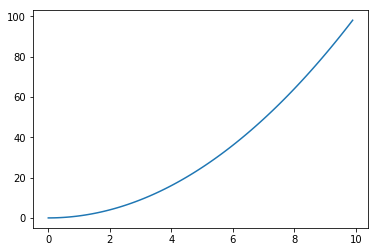

In [22]:
import numpy as np
from astropy.table import Table
%matplotlib inline
import matplotlib.pyplot as plt

a = np.arange(0,10,0.1)
b = a**2
t1 = Table([a, b], names=('a', 'b'))

plt.plot(t1['a'],t1['b']);

To show the table in a browser in a nicely formatted manner, you can do:

```python
t1.show_in_browser()
```

### Saving a table

Writing out a table is also quite simple:

```python
# Writing out FITS table:
t1.write(filename.fits)
# Writing out specific text type:
t1.write(filename.txt,format=‘ascii.tab’)
# Can even write out to LaTeX:
t1.write(filename.tex, format=‘ascii.latex’)
```

In [23]:
t1.write('table.txt',format='ascii.tab',overwrite=True)

## Astronomical units

Astropy
provides a way to manipulate quantities, automatically taking care of unit conversions automatically.

```python
from astropy import units as u
# Defining Quantities with units:
val1, val2 = 30.2 * u.cm, 2.2E4 * u.s
val3 = val1/val2 # Will be units cm / s
# Converting Units
val3km = val3.to(u.km/u.s)
# Simplifying Units
val4 = (10.3 * u.s/ (3 * u.Hz)).decompose()
```

In [24]:
from astropy import units as u

val = 30.0 * u.cm
print(val.to(u.km))

# convert
val1 = 10 * u.km
val2 = 100. * u.m

# simplify
print((val1/val2).decompose())

0.00030000000000000003 km
100.0


## Astronomical constants

Astropy
also provides constants (with units).

```python
from astropy import constants as c
# Some constants
c.k_B, c.c, c.M_sun, c.L_sun
# Can use with units
energy = c.h* 30 * u.Ghz
# Can convert units
mass = (3.2E13 * u.kg).to(c.M_sun)
```

The list of available constant is on:  http://docs.astropy.org/en/stable/constants/

In [25]:
from astropy import constants as c


print('solar mass: ', c.M_sun.value, c.M_sun.unit,'\n')

print (c.c)

solar mass:  1.9884754153381438e+30 kg 

  Name   = Speed of light in vacuum
  Value  = 299792458.0
  Uncertainty  = 0.0
  Unit  = m / s
  Reference = CODATA 2014


Most constant can be converted in cgs units simply using the "cgs" method:

In [26]:
print(c.c.cgs)

29979245800.0 cm / s


## Astronomical query


There are lots of possible databases to query with astroquery. Let's see an example with
the SDSS query.

To access the SDSS, there is a package called astroquery.sdss.
We will import this and also the coordinate package from astropy.
Let's look for a particular object and explore its FITS files for imaging and spectroscopy.
We require the object to be selected only if the spectrum is available in SDSS.

In [27]:
from astroquery.sdss import SDSS
from astropy import coordinates as coords
pos = coords.SkyCoord('13h10m27.46s +18d26m17.4s', 
                      frame='icrs')
xid = SDSS.query_region(pos, spectro=True)
xid

/home/marleau/anaconda3/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "
/home/marleau/anaconda3/lib/python3.6/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


ra,dec,objid,run,rerun,camcol,field,z,plate,mjd,fiberID,specobjid,run2d,instrument
float64,float64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,bytes4
197.614455642896,18.438168853724,1237668296598749280,5314,301,1,136,0.0124487,2618,54506,310,2947691243863304192,26,SDSS


Now, we can get the spectra and images for this list of objects using the following commands. We will obtain a list with as many objects a the list from **xid**.
In this case, only one object.

In [28]:
sp = SDSS.get_spectra(matches=xid)
im = SDSS.get_images(matches=xid, band='r')

print(len(sp), len(im))

1 1


We can also access the SDSS template library. For instance, we will get **qso** template with the command:

In [29]:
template = SDSS.get_spectral_template('qso')
print(len(template))

1


Let's go back to our image. 
In this case the HDU list is the first element of the list.
We can explore what is inside using the **.info** method:

In [30]:
hdulist = im[0]
hdulist.info()

Filename: (No file associated with this HDUList)
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      96   (2048, 1489)   float32   
  1                1 ImageHDU         6   (2048,)   float32   
  2                1 BinTableHDU     27   1R x 3C   [49152E, 2048E, 1489E]   
  3                1 BinTableHDU     79   1R x 31C   [J, 3A, J, A, D, D, 2J, J, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, D, E, E]   


Now, let's get the data.


(1489, 2048) float32


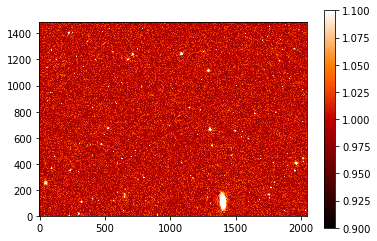

In [31]:
header = hdulist[0].header
data = hdulist[0].data      # image in 1st extension
print (data.shape, data.dtype.name)
#data = hdulist['PRIMARY'].data  
#print (data.shape, data.dtype.name)

import numpy as np
plt.imshow(np.sqrt(data+1.),origin='lower', 
           cmap='gist_heat',vmax=1.1,vmin=0.9)
plt.colorbar();

In the case we want to display the histogram of intensity values:

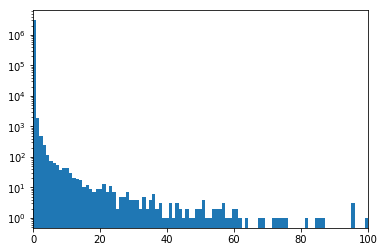

In [32]:
# How to display an histogram of the intensity values 
fig,ax = plt.subplots()
ax.set_yscale('log')
ax.hist(data.ravel(),200)
ax.set_xlim([0,100]);

We can be interested in displaying the image with astrometry.
Let's consider a cutout around the target galaxy and overlap the contours.

In [33]:
c0 = SkyCoord('13h10m27.46s','18d26m17.4s',frame='icrs')
wcs = WCS(header)
center = wcs.all_world2pix(c0.ra,c0.dec,0)
size=400
cutout = Cutout2D(data, center, size, wcs=wcs)

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


/home/marleau/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1004: UserWarning: The following kwargs were not used by contour: 'color'
  s)


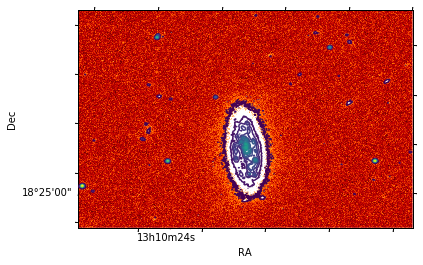

In [34]:
ax = plt.subplot(projection=cutout.wcs)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss') 
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss') 
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(np.sqrt(cutout.data+1.), cmap='gist_heat', 
          origin='lower',vmax=1.1,vmin=0.9,aspect='auto');

a = np.sqrt(cutout.data+1.)
mina=np.min(a)
maxa=np.max(a)
levels = np.arange(mina,maxa,(maxa-mina)/20.)
labels = [item.get_text() for item in 
          ax.get_xticklabels()]
ax.contour(a,levels,color='cyan');

In [35]:
from astroquery.ukidss import Ukidss
import astropy.units as u
import astropy.coordinates as coord

image_ulrs = Ukidss.get_image_list(c0,frame_type='interleave',radius=5 * u.arcmin, waveband='K',programme_id='LAS')


### Overplot two images with different astrometry

In [36]:
from astroquery.skyview import SkyView
survey = 'WISE 12'
sv = SkyView()
paths = sv.get_images(position='M 82',
                      survey=['WISE 12','GALEX Near UV'])


In [37]:
from astropy.wcs import WCS
wcs1 = WCS(paths[0][0].header)
wcs2 = WCS(paths[1][0].header)


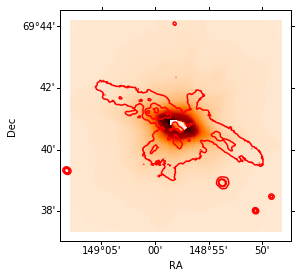

In [38]:
fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection=wcs1)
ax.imshow(paths[0][0].data, origin='lower', 
          cmap='gist_heat_r')
ima2 = paths[1][0].data
levels = np.arange(np.nanmin(ima2),np.nanmax(ima2), 1.)
levels = np.nanmin(ima2)+[0.02,0.09,0.2]
ax.contour(ima2,levels, transform=ax.get_transform(wcs2),
           colors='r')

plt.xlabel('RA')
plt.ylabel('Dec')
plt.show()


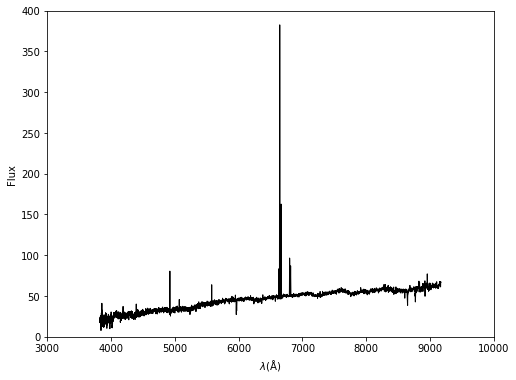

In [39]:
hdulist = sp[0]
#hdulist.info()

data = hdulist[1].data  # assume the first extension is a table
cols = hdulist[1].columns
#cols.info()

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(10**data.loglam,data.flux, '-k', lw=1)

ax.set_xlim(3000, 10000)
ax.set_ylim(0, 400)

ax.set_xlabel(r'$\lambda {(\rm \AA)}$')
ax.set_ylabel('Flux')

plt.show()

In [44]:
#Row-stacked spectrum (RSS)
!rsync -avz rsync://data.sdss.org/dr13/manga/spectro/redux/v1_5_4/7443/stack/manga-7443-12703-LOGRSS.fits.gz .

**********************************************************************
NOTICE TO USERS

You have reached the SDSS rsync server. Access to SDSS data
is provided without any guarantees whatsoever. In addition, access
is subject to these conditions:

 * No more than ten (10) connections are permitted.
 * No warnings will be given if the rsync server needs to be 
   rebooted or otherwise taken offline.
 * Long-running or otherwise excessive rsync jobs are subject to
   termination without notice.
 * The SDSS data set comprises many terabytes, and rsync is
   designed for small data transfers.  If we think you are
   trying to download many terabytes with rsync, that qualifies
   as a long-running or otherwise excessive job.   If you
   need that much data, there are much better tools than rsync
   available. Contact the SDSS Help Desk at helpdesk@sdss.org
   for assistance.

That said, here are some hints for using the SDSS rsync server:

 * If you cannot connect to data.sdss.org, try mirr

In [45]:
#Cube
!rsync -avz rsync://data.sdss.org/dr13/manga/spectro/redux/v1_5_4/7443/stack/manga-7443-12703-LOGCUBE.fits.gz . 

**********************************************************************
NOTICE TO USERS

You have reached the SDSS rsync server. Access to SDSS data
is provided without any guarantees whatsoever. In addition, access
is subject to these conditions:

 * No more than ten (10) connections are permitted.
 * No warnings will be given if the rsync server needs to be 
   rebooted or otherwise taken offline.
 * Long-running or otherwise excessive rsync jobs are subject to
   termination without notice.
 * The SDSS data set comprises many terabytes, and rsync is
   designed for small data transfers.  If we think you are
   trying to download many terabytes with rsync, that qualifies
   as a long-running or otherwise excessive job.   If you
   need that much data, there are much better tools than rsync
   available. Contact the SDSS Help Desk at helpdesk@sdss.org
   for assistance.

That said, here are some hints for using the SDSS rsync server:

 * If you cannot connect to data.sdss.org, try mirr

In [46]:
#Import python modules and load data. 
#Note that the extensions for the MaNGA RSS files are listed in:
#https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/PLATE4/stack/manga-RSS.html

import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits

rss = fits.open('manga-7443-12703-LOGRSS.fits.gz')
flux_rss = rss['FLUX'].data
ivar_rss = rss['IVAR'].data
mask_rss = rss['MASK'].data
wave_rss = rss['WAVE'].data
xpos = rss['XPOS'].data
ypos = rss['YPOS'].data


Text(0,0.5,'1E-17 erg/s/cm^2/Ang/fiber')

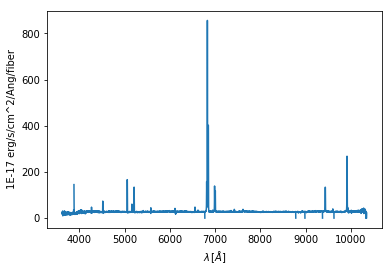

In [47]:
#Plot spectrum of fiber closest to (x=0, y=0) at Hα:
    
# Create masked array to skip plotting of bad pixels
bad_bits = (mask_rss != 0)
flux_rss_m = np.ma.array(flux_rss, mask=bad_bits)

# index element of central fiber for this particular data cube is 1313
ind_center = 1313    
plt.plot(wave_rss, flux_rss_m[ind_center])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(rss['FLUX'].header['BUNIT'])
 

In [48]:
#Import python modules and load data, 
#Note that the extensions for the MaNGA RSS files are listed in:
#https://data.sdss.org/datamodel/files/MANGA_SPECTRO_REDUX/DRPVER/PLATE4/stack/manga-CUBE.html

import os
import numpy as np
import matplotlib.pyplot as plt
from astropy import wcs
from astropy.io import fits

cube = fits.open('manga-7443-12703-LOGCUBE.fits.gz')

# Re-order FLUX, IVAR, and MASK arrays from (wavelength, DEC, RA) to (RA, DEC, wavelength).
flux = np.transpose(cube['FLUX'].data, axes=(2, 1, 0))
ivar = np.transpose(cube['IVAR'].data, axes=(2, 1, 0))
mask = np.transpose(cube['MASK'].data, axes=(2, 1, 0))

wave = cube['WAVE'].data
flux_header = cube['FLUX'].header


Text(0,0.5,'1E-17 erg/s/cm^2/Ang/spaxel')

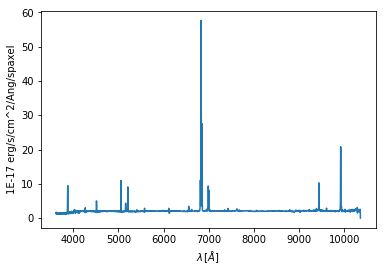

In [49]:
#Note: (x=0, y=0) corresponds to the upper left if North is up and East is left.
#Plot the central spectrum:

x_center = np.int(flux_header['CRPIX1']) - 1
y_center = np.int(flux_header['CRPIX2']) - 1

plt.plot(wave, flux[x_center, y_center])
plt.xlabel('$\lambda \, [\AA]$')
plt.ylabel(flux_header['BUNIT'])


In [50]:
#Find array indices of a particular RA and DEC:

cubeWCS = wcs.WCS(flux_header)
ra = 229.525580000
dec = 42.7458420000
x_cube_coord, y_cube_coord, __ = cubeWCS.wcs_world2pix([[ra, dec, 1.]], 1)[0]
x_spaxel = np.int(np.round(x_cube_coord)) - 1
y_spaxel = np.int(np.round(y_cube_coord)) - 1


a string value was expected. [astropy.wcs.wcs]


In [51]:
#Plot an Hα narrow band image
#Apply bitmasks and select region around Hα:

do_not_use = (mask & 2**10) != 0
flux_m = np.ma.array(flux, mask=do_not_use)

redshift = 0.0402719
ind_wave = np.where((wave / (1 + redshift) > 6550) & (wave / (1 + redshift) < 6680))[0]
halpha = flux_m[:, :, ind_wave].sum(axis=2)
im = halpha.T

# Convert from array indices to arcsec relative to IFU center
dx = flux_header['CD1_1'] * 3600.  # deg to arcsec
dy = flux_header['CD2_2'] * 3600.  # deg to arcsec
x_extent = (np.array([0., im.shape[0]]) - (im.shape[0] - x_center)) * dx * (-1)
y_extent = (np.array([0., im.shape[1]]) - (im.shape[1] - y_center)) * dy
extent = [x_extent[0], x_extent[1], y_extent[0], y_extent[1]]


Text(0,0.5,'arcsec')

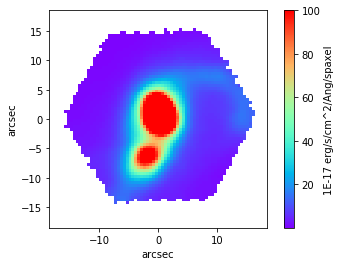

In [52]:
#Generate plot:

plt.imshow(im, extent=extent, cmap='rainbow', vmin=0.1, vmax=100, origin='lower', interpolation='none')
plt.colorbar(label=flux_header['BUNIT'])
plt.xlabel('arcsec')
plt.ylabel('arcsec')
